MIDI Master

In [1]:
import mido
import numpy as np
import pandas as pd
import random
import os
from scipy import stats
import matplotlib.pyplot as plt
from math import log

In [21]:
('midi/demo.midi')

In [22]:
pitch, length,stamp = get_pn(midifile)
pcount,pclass,pctm,pi,pr,ioi,ncount = get_other(pitch, length,stamp,0)

NameError: name 'get_pn' is not defined

In [45]:
midifile = mido.MidiFile('subjective/tr/clip10.midi')

In [46]:
i = 0
for track in midifile.tracks:
    i+=1
    if i == 3:
        midifile.tracks.remove(track)

In [47]:
midifile.save('subjective/tr/tr/clip10.midi')

In [32]:
midifile.tracks

[MidiTrack([
   MetaMessage('set_tempo', tempo=500000, time=0),
   MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
   MetaMessage('end_of_track', time=1)]),
 MidiTrack([
   MetaMessage('track_name', name='chords', time=0),
   Message('program_change', channel=1, program=33, time=0),
   Message('note_on', channel=1, note=45, velocity=38, time=2185),
   Message('note_on', channel=1, note=57, velocity=38, time=0),
   Message('note_on', channel=1, note=61, velocity=38, time=48),
   Message('note_on', channel=1, note=64, velocity=38, time=48),
   Message('note_on', channel=1, note=67, velocity=38, time=48),
   Message('note_on', channel=1, note=38, velocity=35, time=2001),
   Message('note_on', channel=1, note=45, velocity=0, time=0),
   Message('note_on', channel=1, note=50, velocity=35, time=0),
   Message('note_on', channel=1, note=57, velocity=0, time=0),
   Message('note_on', channel=1, note=61, velocity=0, time=0),

In [2]:
def get_pn2_human(csv):
    pitch = []
    length = []
    stamp = []
    bar = 0
    po = 0
    for i in range(len(csv)):
        if csv.iloc[i].EVENT == 'Note-On':
            pitch.append(int(csv.iloc[i].VALUE))
            stamp.append(int(po) + (int(bar)-1)*64)
        elif csv.iloc[i].EVENT == 'Note-Duration':
            length.append(int(csv.iloc[i].VALUE))
        elif csv.iloc[i].EVENT == 'Bar':
            bar+=1
        elif csv.iloc[i].EVENT == 'Position':
            po = csv.iloc[i].VALUE
        if bar > 8:
            break
    return pitch,length,stamp

In [3]:
def get_pn2_l_t(csv):
    pitch = []
    length = []
    stamp = []
    bar = 1
    po = 0
    for i in range(len(csv)):
        if 'Note-On' in csv.iloc[i].EVENT:
            pitch.append(int((csv.iloc[i].EVENT)[8:]))
            stamp.append(int(po) + (int(bar)-1)*64)
        elif 'Note-Duration' in csv.iloc[i].EVENT:
            length.append(int(((csv.iloc[i].EVENT)[14:])[:-3]))
        elif 'Position' in csv.iloc[i].EVENT:
            if po > int(((csv.iloc[i].EVENT)[9:])[:-3]):
                bar += 1
            po = int(((csv.iloc[i].EVENT)[9:])[:-3])
    return pitch,length,stamp

In [4]:
def get_other(pitch,length,stamp,cut):
    pitch = pitch[cut:]
    length = length[cut:]
    stamp = stamp[cut:]
    pcount = len(set(pitch))
    pclasser = [(x%12) for x in pitch]
    pclass = np.zeros(12)
    for i in range(len(pclasser)):
        pclass[pclasser[i]] += 1
    pctm = np.zeros((12,12))
    pi = 0
    for i in range(len(pclasser)-1):
        pctm[pclasser[i]][pclasser[i+1]] += 1
        pi += abs(pitch[i+1] - pitch[i])
    pi = pi/len(pitch)
    for i in range(12):
        if np.sum(pctm[i])!= 0:
            pctm[i] = pctm[i]/np.sum(pctm[i])
    pr = np.max(pitch) - np.min(pitch)
    ioi = (stamp[-1]-stamp[0])/len(stamp)
    ncount = len(pitch)
    nlher = []
    nlh = np.zeros(16)
    for i in range(len(length)):
        if length[i] < 64:
            nlher.append(length[i]//4)
        else:
            nlher.append(15)
    for i in range(len(nlher)):
        nlh[nlher[i]] += 1    
    nltm = np.zeros((16,16))
    for i in range(len(nlher)-1):
        nltm[nlher[i]-1][nlher[i+1]-1] += 1
    for i in range(16):
        if np.sum(nltm[i])!= 0:
            nltm[i] = nltm[i]/np.sum(nltm[i])
    return pcount,pclass,pctm,pi,pr,ioi,ncount,nlh,nltm

In [5]:
class solo(object):
    def __init__(self,pcount,pclass,pctm,pi,pr,ioi,ncount,nlh,nltm):
        self.pcount = pcount
        self.pclass = pclass
        self.pctm = pctm
        self.pi = pi
        self.pr = pr
        self.ioi = ioi
        self.ncount = ncount
        self.nlh = nlh
        self.nltm = nltm

In [6]:
human = []
i=1
for root,dirs,files in os.walk('midi/human'):
    for f in files:
        data = pd.read_csv(os.path.join(root, f))
        p,l,s=get_pn2_human(data)
        pcount,pclass,pctm,pi,pr,ioi,ncount,nlh,nltm = get_other(p,l,s,0)
        solo1 = solo(pcount,pclass,pctm,pi,pr,ioi,ncount,nlh,nltm)
        human.append(solo1)
        if i<30:
            i+=1
        else:
            break
# for i in range(1,31):
#     data = pd.read_csv('midi/human/output'+str(i)+'.csv')
#     p,l,s=get_pn2_human(data)
#     pcount,pclass,pctm,pi,pr,ioi,ncount,nlh,nltm = get_other(p,l,s,0)
#     solo1 = solo(pcount,pclass,pctm,pi,pr,ioi,ncount,nlh,nltm)
#     human.append(solo1)
trans = []
for i in range(1,31):
    data = pd.read_csv('midi/transformer/output'+str(i)+'.csv')
    p,l,s=get_pn2_l_t(data)
    pcount,pclass,pctm,pi,pr,ioi,ncount,nlh,nltm = get_other(p,l,s,0)
    solo1 = solo(pcount,pclass,pctm,pi,pr,ioi,ncount,nlh,nltm)
    trans.append(solo1)
lstm = []
for i in range(1,31):
    data = pd.read_csv('midi/lstm/output'+str(i)+'.csv')
    p,l,s=get_pn2_l_t(data)
    pcount,pclass,pctm,pi,pr,ioi,ncount,nlh,nltm = get_other(p,l,s,0)
    solo1 = solo(pcount,pclass,pctm,pi,pr,ioi,ncount,nlh,nltm)
    lstm.append(solo1)

In [135]:
len(trans)

30

In [7]:
def get_absolute(solos):
    pcount = []
    pi = []
    pr = []
    ioi = []
    ncount = []
    pch = np.zeros(12)
    nlh = np.zeros(16)
    for i in range(len(solos)):
        pcount.append(abs(solos[i].pcount))
        pi.append(abs(solos[i].pi))
        pr.append(abs(solos[i].pr))
        ioi.append(abs(solos[i].ioi))
        ncount.append(abs(solos[i].ncount))
        pch = pch + solos[i].pclass
        nlh = nlh + solos[i].nlh
    print('PC: Mean: '+ str(np.mean(pcount)) + '  STD: '+ str(np.std(pcount)))
    print('PR: Mean: '+ str(np.mean(pr)) + '  STD: '+ str(np.std(pr)))
    print('PI: Mean: '+ str(np.mean(pi)) + '  STD: '+ str(np.std(pi)))
    print('NC: Mean: '+ str(np.mean(ncount)) + '  STD: '+ str(np.std(ncount)))
    print('IOI: Mean: '+ str(np.mean(ioi)) + '  STD: '+ str(np.std(ioi)))
    return pch,nlh

In [8]:
def get_intra(solos):
    pcount = []
    pclass = []
    pctm = []
    pi = []
    pr = []
    ioi = []
    ncount = []
    nlh = []
    nltm = []
    for i in range(len(solos)):
        for j in range(i+1,len(solos)):
            pcount.append(abs(solos[i].pcount-solos[j].pcount))
            pclass.append(np.sqrt(np.sum(np.square(np.array(solos[i].pclass)-np.array(solos[j].pclass)))))
            pctm.append(np.sqrt(np.sum(np.square(solos[i].pctm-solos[j].pctm))))
            pi.append(abs(solos[i].pi-solos[j].pi))
            pr.append(abs(solos[i].pr-solos[j].pr))
            ioi.append(abs(solos[i].ioi-solos[j].ioi))
            ncount.append(abs(solos[i].ncount-solos[j].ncount))
            nlh.append(np.sqrt(np.sum(np.square(np.array(solos[i].nlh)-np.array(solos[j].nlh)))))
            nltm.append(np.sqrt(np.sum(np.square(solos[i].nltm-solos[j].nltm))))
    
    print('PC: Mean: '+ str(np.mean(pcount)) + '  STD: '+ str(np.std(pcount)))
    print('PCH: Mean: '+ str(np.mean(pclass)) + '  STD: '+ str(np.std(pclass)))
    print('PCTM: Mean: '+ str(np.mean(pctm)) + '  STD: '+ str(np.std(pctm)))
    print('PR: Mean: '+ str(np.mean(pr)) + '  STD: '+ str(np.std(pr)))
    print('PI: Mean: '+ str(np.mean(pi)) + '  STD: '+ str(np.std(pi)))
    print('NC: Mean: '+ str(np.mean(ncount)) + '  STD: '+ str(np.std(ncount)))
    print('IOI: Mean: '+ str(np.mean(ioi)) + '  STD: '+ str(np.std(ioi)))
    print('NLH: Mean: '+ str(np.mean(nlh)) + '  STD: '+ str(np.std(nlh)))
    print('NLTM: Mean: '+ str(np.mean(nltm)) + '  STD: '+ str(np.std(nltm)))
    return pcount,pclass,pctm,pi,pr,ioi,ncount,nlh,nltm

In [9]:
def get_inter(solos1,solos2):
    pcount = []
    pclass = []
    pctm = []
    pi = []
    pr = []
    ioi = []
    ncount = []
    nlh = []
    nltm = []
    for i in range(len(solos1)):
        for j in range(len(solos2)):
            pcount.append(abs(solos1[i].pcount-solos2[j].pcount))
            pclass.append(np.sqrt(np.sum(np.square(np.array(solos1[i].pclass)-np.array(solos2[j].pclass)))))
            pctm.append(np.sqrt(np.sum(np.square(solos1[i].pctm-solos2[j].pctm))))
            pi.append(abs(solos1[i].pi-solos2[j].pi))
            pr.append(abs(solos1[i].pr-solos2[j].pr))
            ioi.append(abs(solos1[i].ioi-solos2[j].ioi))
            ncount.append(abs(solos1[i].ncount-solos2[j].ncount))
            nlh.append(np.sqrt(np.sum(np.square(np.array(solos1[i].nlh)-np.array(solos2[j].nlh)))))
            nltm.append(np.sqrt(np.sum(np.square(solos1[i].nltm-solos2[j].nltm))))
    print('PC: Mean: '+ str(np.mean(pcount)) + '  STD: '+ str(np.std(pcount)) + '  KLD: '+ str(stats.entropy(pcount)))
    print('PCH: Mean: '+ str(np.mean(pclass)) + '  STD: '+ str(np.std(pclass)) + '  KLD: '+ str(stats.entropy(pclass)))
    print('PCTM: Mean: '+ str(np.mean(pctm)) + '  STD: '+ str(np.std(pctm)) + '  KLD: '+ str(stats.entropy(pctm)))
    print('PR: Mean: '+ str(np.mean(pr)) + '  STD: '+ str(np.std(pr)) + '  KLD: '+ str(stats.entropy(pr)))
    print('PI: Mean: '+ str(np.mean(pi)) + '  STD: '+ str(np.std(pi)) + '  KLD: '+ str(stats.entropy(pi)))
    print('NC: Mean: '+ str(np.mean(ncount)) + '  STD: '+ str(np.std(ncount)) + '  KLD: '+ str(stats.entropy(ncount)))
    print('IOI: Mean: '+ str(np.mean(ioi)) + '  STD: '+ str(np.std(ioi)) + '  KLD: '+ str(stats.entropy(ioi)))
    print('NLH: Mean: '+ str(np.mean(nlh)) + '  STD: '+ str(np.std(nlh)) + '  KLD: '+ str(stats.entropy(nlh)))
    print('NLTM: Mean: '+ str(np.mean(nltm)) + '  STD: '+ str(np.std(nltm)) + '  KLD: '+ str(stats.entropy(nltm)))
    return pcount,pclass,pctm,pi,pr,ioi,ncount,nlh,nltm


In [10]:
def kld(x,y):
    k_x = set(x)
    p = []
    for i in k_x:
        p.append(x.count(i) / len(x))

    k_y = set(y)
    q = []
    for i in k_y:
        q.append(y.count(i) / len(y))

    KL = 0.0
    k = 0
    if len(k_x)>len(k_y):
        k = len(k_y)
        for i in range(k):
            KL += q[i] * log(q[i] / p[i], 2)
    else:
        k = len(k_x)
        for i in range(k):
            KL += p[i] * log(p[i] / q[i], 2)

    return round(KL, 5)

In [25]:
def get_kldoa(solos1,solos2):
    pc1,pch1,pctm1,pi1,pr1,ioi1,nc1,nlh1,nltm1 = get_intra(solos1)
    pc2,pch2,pctm2,pi2,pr2,ioi2,nc2,nlh2,nltm2 = get_inter(solos1,solos2)
    print('PC:   KLD: '+ str(kld(pc1,pc2)))
    print('PCH:   KLD: '+ str(kld(pch1,pch2)))
    print('PCTM:   KLD: '+ str(kld(pctm1,pctm2)))
    print('PR:  KLD: '+ str(kld(pr1,pr2)))
    print('PI:  KLD: '+ str(kld(pi1,pi2)))
    print('NC:  KLD: '+ str(kld(nc1,nc2)))
    print('IOI:   KLD: '+ str(kld(ioi1,ioi2)))
    print('NLH:  KLD: '+ str(kld(nlh1,nlh2)))
    print('NLTM:  KLD: '+ str(kld(nltm1,nltm2)))

In [88]:
pc1,pch1,pctm1,pi1,pr1,ioi1,nc1,nlh1,nltm1 = get_intra(human)

PC: Mean: 5.788505747126437  STD: 4.025362846138273
PCH: Mean: 17.76620611625084  STD: 6.269692709509206
PCTM: Mean: 2.9424790308434963  STD: 0.3433394585064834
PR: Mean: 5.836781609195402  STD: 4.242481244887831
PI: Mean: 0.7397653423512317  STD: 0.6606763981567458
NC: Mean: 24.887356321839082  STD: 18.647700573773882
IOI: Mean: 5.813760059237169  STD: 5.694176982835668
NLH: Mean: 29.70487473933769  STD: 19.22132922510896
NLTM: Mean: 2.1278567296219553  STD: 0.47812783752448235


In [89]:
pc2,pch2,pctm2,pi2,pr2,ioi2,nc2,nlh2,nltm2 = get_intra(trans)

PC: Mean: 6.395402298850574  STD: 4.848981598161109
PCH: Mean: 25.46678713716009  STD: 11.329099701080143
PCTM: Mean: 2.7833288565524255  STD: 0.28719718507931513
PR: Mean: 6.563218390804598  STD: 4.994482356538736
PI: Mean: 0.7786707770622973  STD: 0.6740202858203135
NC: Mean: 39.232183908045975  STD: 32.06672459520972
IOI: Mean: 5.604736201529403  STD: 4.03887017086514
NLH: Mean: 43.983615319127544  STD: 34.23291045429314
NLTM: Mean: 2.1539104297423095  STD: 0.4952237914076894


In [90]:
pc3,pch3,pctm3,pi3,pr3,ioi3,nc3,nlh3,nltm3 = get_intra(lstm)

PC: Mean: 2.682758620689655  STD: 2.051195720613897
PCH: Mean: 26.518625565188493  STD: 15.311605296441682
PCTM: Mean: 2.5555123335443035  STD: 0.41206211125567127
PR: Mean: 6.163218390804598  STD: 4.46735579542084
PI: Mean: 0.7542130802288828  STD: 0.5739001702397328
NC: Mean: 24.05977011494253  STD: 20.568385850593064
IOI: Mean: 4.998350475348378  STD: 3.5009574800788985
NLH: Mean: 31.79692042973792  STD: 23.030204817663613
NLTM: Mean: 1.184530940327004  STD: 0.5649073438585833


In [91]:
pc4,pch4,pctm4,pi4,pr4,ioi4,nc4,nlh4,nltm4 = get_inter(trans,human)

PC: Mean: 5.96  STD: 4.436034264971361  KLD: 6.514045318121799
PCH: Mean: 22.027640959129997  STD: 9.895943635769417  KLD: 6.711908055204134
PCTM: Mean: 2.8693299558890977  STD: 0.30079394795516234  KLD: 6.7968827755243
PR: Mean: 6.0488888888888885  STD: 4.632235947848858  KLD: 6.505233762310564
PI: Mean: 0.7457302610027599  STD: 0.6638321199678047  KLD: 6.434697656689653
NC: Mean: 32.611111111111114  STD: 28.231107525188687  KLD: 6.461245799038095
IOI: Mean: 5.778281715586355  STD: 5.013896784121736  KLD: 6.472634491780661
NLH: Mean: 37.70817047821389  STD: 29.543611666434252  KLD: 6.545251171374558
NLTM: Mean: 2.154594255616542  STD: 0.4841383980746049  KLD: 6.775520951835217


In [92]:
pc5,pch5,pctm5,pi5,pr5,ioi5,nc5,nlh5,nltm5 = get_inter(lstm,human)

PC: Mean: 9.08  STD: 5.243433989286029  KLD: 6.61918795377199
PCH: Mean: 24.998483304562203  STD: 13.104717099170914  KLD: 6.677037280518212
PCTM: Mean: 2.9060297269978066  STD: 0.28415048726570663  KLD: 6.79755749957817
PR: Mean: 8.515555555555556  STD: 6.033865742827656  KLD: 6.539781736665253
PI: Mean: 1.640364799712848  STD: 0.905676075203755  KLD: 6.637981914452229
NC: Mean: 27.613333333333333  STD: 20.05917468114999  KLD: 6.534122169383274
IOI: Mean: 5.526738190575872  STD: 4.501780202134078  KLD: 6.499081765420746
NLH: Mean: 38.27510416518348  STD: 21.272537356620116  KLD: 6.649942148506334
NLTM: Mean: 1.8917427739701327  STD: 0.4356618757470073  KLD: 6.77424899306145


In [75]:
values1=pd.Series(np.array(nc3))
values2=pd.Series(np.array(nc5))

Text(0.5, 0, 'Euclidean distance')

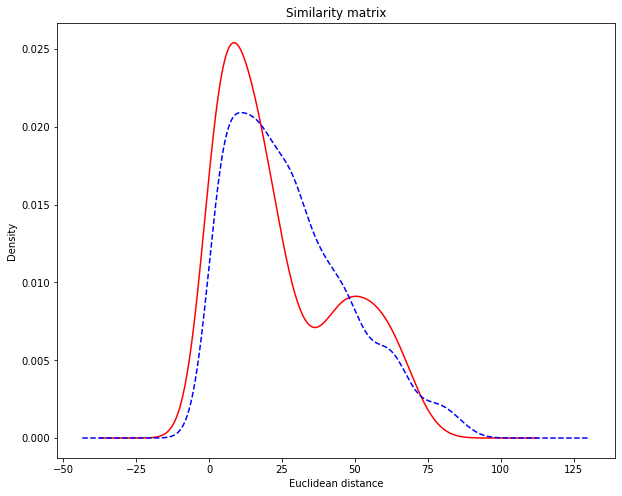

In [76]:
plt.figure(figsize=(10,8))
values1.plot(kind='kde',style = 'r-')
values2.plot(kind='kde',style='b--')
plt.title('Similarity matrix')
plt.xlabel('Euclidean distance')

In [26]:
get_kldoa(trans,human)

PC: Mean: 6.395402298850574  STD: 4.848981598161109
PCH: Mean: 25.46678713716009  STD: 11.329099701080143
PCTM: Mean: 2.7833288565524255  STD: 0.28719718507931513
PR: Mean: 6.563218390804598  STD: 4.994482356538736
PI: Mean: 0.7786707770622973  STD: 0.6740202858203135
NC: Mean: 39.232183908045975  STD: 32.06672459520972
IOI: Mean: 5.604736201529403  STD: 4.03887017086514
NLH: Mean: 43.983615319127544  STD: 34.23291045429314
NLTM: Mean: 2.1539104297423095  STD: 0.4952237914076894
PC: Mean: 5.96  STD: 4.436034264971361  KLD: 6.514045318121799
PCH: Mean: 22.027640959129997  STD: 9.895943635769417  KLD: 6.711908055204134
PCTM: Mean: 2.8693299558890977  STD: 0.30079394795516234  KLD: 6.7968827755243
PR: Mean: 6.0488888888888885  STD: 4.632235947848858  KLD: 6.505233762310564
PI: Mean: 0.7457302610027599  STD: 0.6638321199678047  KLD: 6.434697656689653
NC: Mean: 32.611111111111114  STD: 28.231107525188687  KLD: 6.461245799038095
IOI: Mean: 5.778281715586355  STD: 5.013896784121736  KLD: 6.47

In [27]:
get_kldoa(lstm,human)

PC: Mean: 2.682758620689655  STD: 2.051195720613897
PCH: Mean: 26.518625565188493  STD: 15.311605296441682
PCTM: Mean: 2.5555123335443035  STD: 0.41206211125567127
PR: Mean: 6.163218390804598  STD: 4.46735579542084
PI: Mean: 0.7542130802288828  STD: 0.5739001702397328
NC: Mean: 24.05977011494253  STD: 20.568385850593064
IOI: Mean: 4.998350475348378  STD: 3.5009574800788985
NLH: Mean: 31.79692042973792  STD: 23.030204817663613
NLTM: Mean: 1.184530940327004  STD: 0.5649073438585833
PC: Mean: 9.08  STD: 5.243433989286029  KLD: 6.61918795377199
PCH: Mean: 24.998483304562203  STD: 13.104717099170914  KLD: 6.677037280518212
PCTM: Mean: 2.9060297269978066  STD: 0.28415048726570663  KLD: 6.79755749957817
PR: Mean: 8.515555555555556  STD: 6.033865742827656  KLD: 6.539781736665253
PI: Mean: 1.640364799712848  STD: 0.905676075203755  KLD: 6.637981914452229
NC: Mean: 27.613333333333333  STD: 20.05917468114999  KLD: 6.534122169383274
IOI: Mean: 5.526738190575872  STD: 4.501780202134078  KLD: 6.4990

In [120]:
values1=pd.Series(np.array(pctm1))
values2=pd.Series(np.array(pctm2))
values3=pd.Series(np.array(pctm3))
values4=pd.Series(np.array(pctm4))
values5=pd.Series(np.array(pctm5))

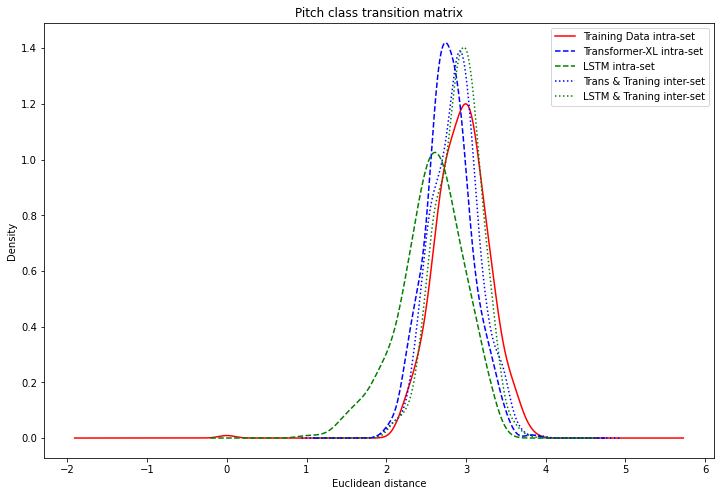

In [121]:
plt.figure(figsize=(12,8))
values1.plot(kind='kde',style = 'r-',label = 'Training Data intra-set')
values2.plot(kind='kde',style='b--',label = 'Transformer-XL intra-set')
values3.plot(kind='kde',style='g--',label = 'LSTM intra-set')
values4.plot(kind='kde',style='b:',label = 'Trans & Traning inter-set')
values5.plot(kind='kde',style='g:',label = 'LSTM & Traning inter-set')
plt.title('Pitch class transition matrix')
plt.xlabel('Euclidean distance')
plt.legend()
plt.show()

<AxesSubplot:ylabel='Density'>

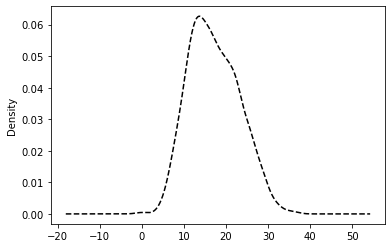

In [131]:
values.plot(kind='kde',style='k--')

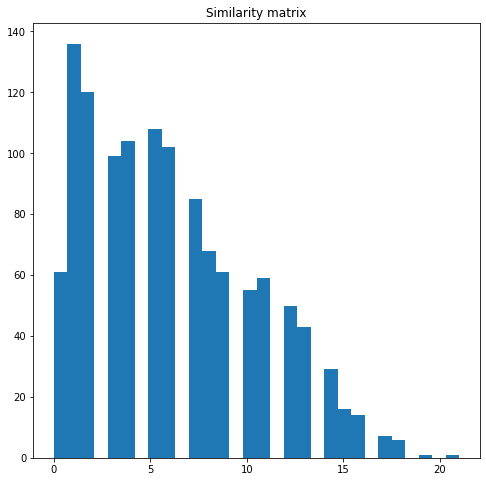

In [116]:
plt.figure(figsize=(8,8))
plt.hist(pc,bins=30)
plt.title('Similarity matrix')
plt.show()

In [24]:
get_intra(trans)

([3,
  10,
  5,
  1,
  15,
  6,
  1,
  15,
  1,
  0,
  4,
  20,
  5,
  6,
  10,
  12,
  5,
  9,
  4,
  5,
  1,
  3,
  9,
  2,
  0,
  9,
  3,
  2,
  2,
  7,
  2,
  2,
  12,
  3,
  4,
  12,
  4,
  3,
  1,
  17,
  2,
  3,
  7,
  9,
  2,
  6,
  1,
  2,
  2,
  6,
  6,
  5,
  3,
  6,
  0,
  1,
  5,
  5,
  9,
  5,
  4,
  11,
  5,
  11,
  10,
  6,
  10,
  5,
  4,
  0,
  2,
  5,
  1,
  6,
  5,
  9,
  13,
  1,
  12,
  10,
  1,
  7,
  8,
  12,
  4,
  10,
  1,
  6,
  10,
  6,
  5,
  1,
  15,
  0,
  1,
  5,
  7,
  0,
  4,
  1,
  0,
  4,
  8,
  4,
  7,
  5,
  4,
  2,
  3,
  7,
  14,
  5,
  2,
  14,
  2,
  1,
  3,
  19,
  4,
  5,
  9,
  11,
  4,
  8,
  3,
  4,
  0,
  4,
  8,
  3,
  1,
  8,
  2,
  1,
  3,
  9,
  16,
  0,
  16,
  15,
  11,
  5,
  10,
  9,
  5,
  3,
  10,
  6,
  11,
  10,
  14,
  18,
  6,
  17,
  15,
  6,
  12,
  13,
  17,
  7,
  9,
  7,
  6,
  2,
  14,
  1,
  0,
  4,
  6,
  1,
  3,
  2,
  1,
  5,
  9,
  3,
  8,
  6,
  3,
  3,
  4,
  8,
  16,
  0,
  1,
  5,
  21,
  6,
  7,
  11,
  13,
 

In [70]:
get_intra(lstm)

PC: Mean: 3.1894736842105265  STD: 2.306944832420965
PCH: Mean: 30.064423954177986  STD: 15.96390308718808
PCTM: Mean: 2.2550877160056277  STD: 0.39330908917028773
PR: Mean: 6.705263157894737  STD: 4.819638956144955
PI: Mean: 0.7597760431011086  STD: 0.6208803908398886
NC: Mean: 29.31578947368421  STD: 21.113110498054215
IOI: Mean: 7.303533469555932  STD: 5.119270773496212
NLH: Mean: 39.242089570109236  STD: 21.340238391184304
NLTM: Mean: 1.842826655915376  STD: 0.5415125704520821


In [75]:
get_inter(trans,lstm)

PC: Mean: 10.665  STD: 6.190135297390519
PCH: Mean: 31.622239728284057  STD: 13.351365269774234
PCTM: Mean: 2.7702108079288656  STD: 0.2566127834729704
PR: Mean: 9.435  STD: 6.654380136421422
PI: Mean: 1.6913070990512  STD: 0.870282601518216
NC: Mean: 37.7  STD: 27.97981415234919
IOI: Mean: 7.100472903351034  STD: 5.317987512953772
NLH: Mean: 43.02257830983427  STD: 19.511605663660227
NLTM: Mean: 2.800709848976337  STD: 0.4574489793593985


In [88]:
pch1,nlh1 = get_absolute(lstm)

PC: Mean: 6.233333333333333  STD: 2.3478122203920444
PR: Mean: 11.166666666666666  STD: 5.292027546749502
PI: Mean: 1.093549452812771  STD: 0.6588849734955826
NC: Mean: 34.0  STD: 22.006059771496275
IOI: Mean: 12.543727861387021  STD: 4.242574123886615


In [89]:
pch2,nlh2 = get_absolute(human)

PC: Mean: 15.68  STD: 5.2055355151991805
PR: Mean: 18.86  STD: 5.027961813697474
PI: Mean: 2.6397574383655917  STD: 0.6008664890051325
NC: Mean: 49.8  STD: 22.049943310584723
IOI: Mean: 11.2932115670286  STD: 5.250705640646642


In [90]:
pch3,nlh3 = get_absolute(trans)

PC: Mean: 15.0  STD: 5.579725202313581
PR: Mean: 18.7  STD: 5.733817808987888
PI: Mean: 2.6133296939285438  STD: 0.7159878283147797
NC: Mean: 60.93333333333333  STD: 35.226820590125485
IOI: Mean: 9.789340178974358  STD: 4.802847530769836


In [91]:
nlh1

array([835., 151.,  33.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

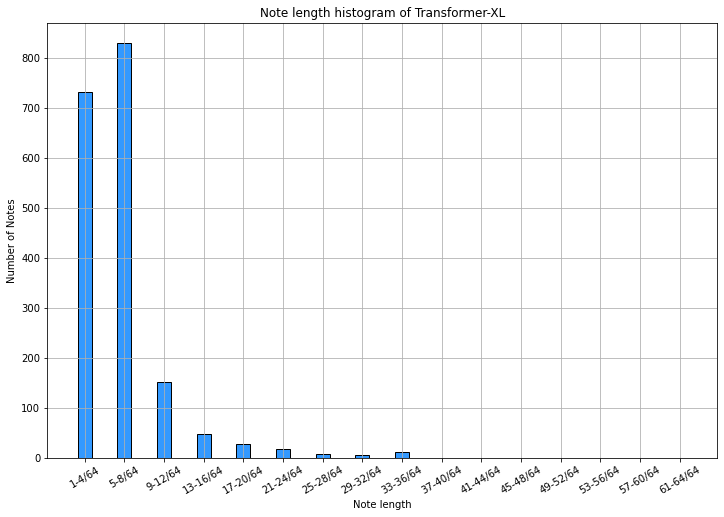

In [99]:
plt.figure(figsize=(12,8))
x=["1-4/64", "5-8/64", "9-12/64", "13-16/64", "17-20/64", "21-24/64", "25-28/64", "29-32/64", "33-36/64", "37-40/64", "41-44/64", "45-48/64","49-52/64","53-56/64","57-60/64","61-64/64"]
plt.bar(x,nlh3,label='number of pitch',color = '#3399FF',width = 0.35,edgecolor = 'black',bottom = 0)
plt.title('Note length histogram of Transformer-XL')
plt.xlabel('Note length')
plt.ylabel('Number of Notes')
plt.grid()
plt.xticks(rotation=30)
plt.show()

In [1]:
import numpy as np
import pretty_midi
import matplotlib.pyplot as plt
import keras
import scipy.signal
from scipy.ndimage import filters
import cv2

In [2]:
filter_size = 256
standard_deviation = 128
p = print

In [17]:
file_name = 'midi/tr1.midi'
pm = pretty_midi.PrettyMIDI(file_name)
piano_roll = pm.get_piano_roll(fs=5)
Tx = len(piano_roll[0])

x = np.zeros(shape=(128,Tx))
x[:,:]=piano_roll
x=np.transpose(x)


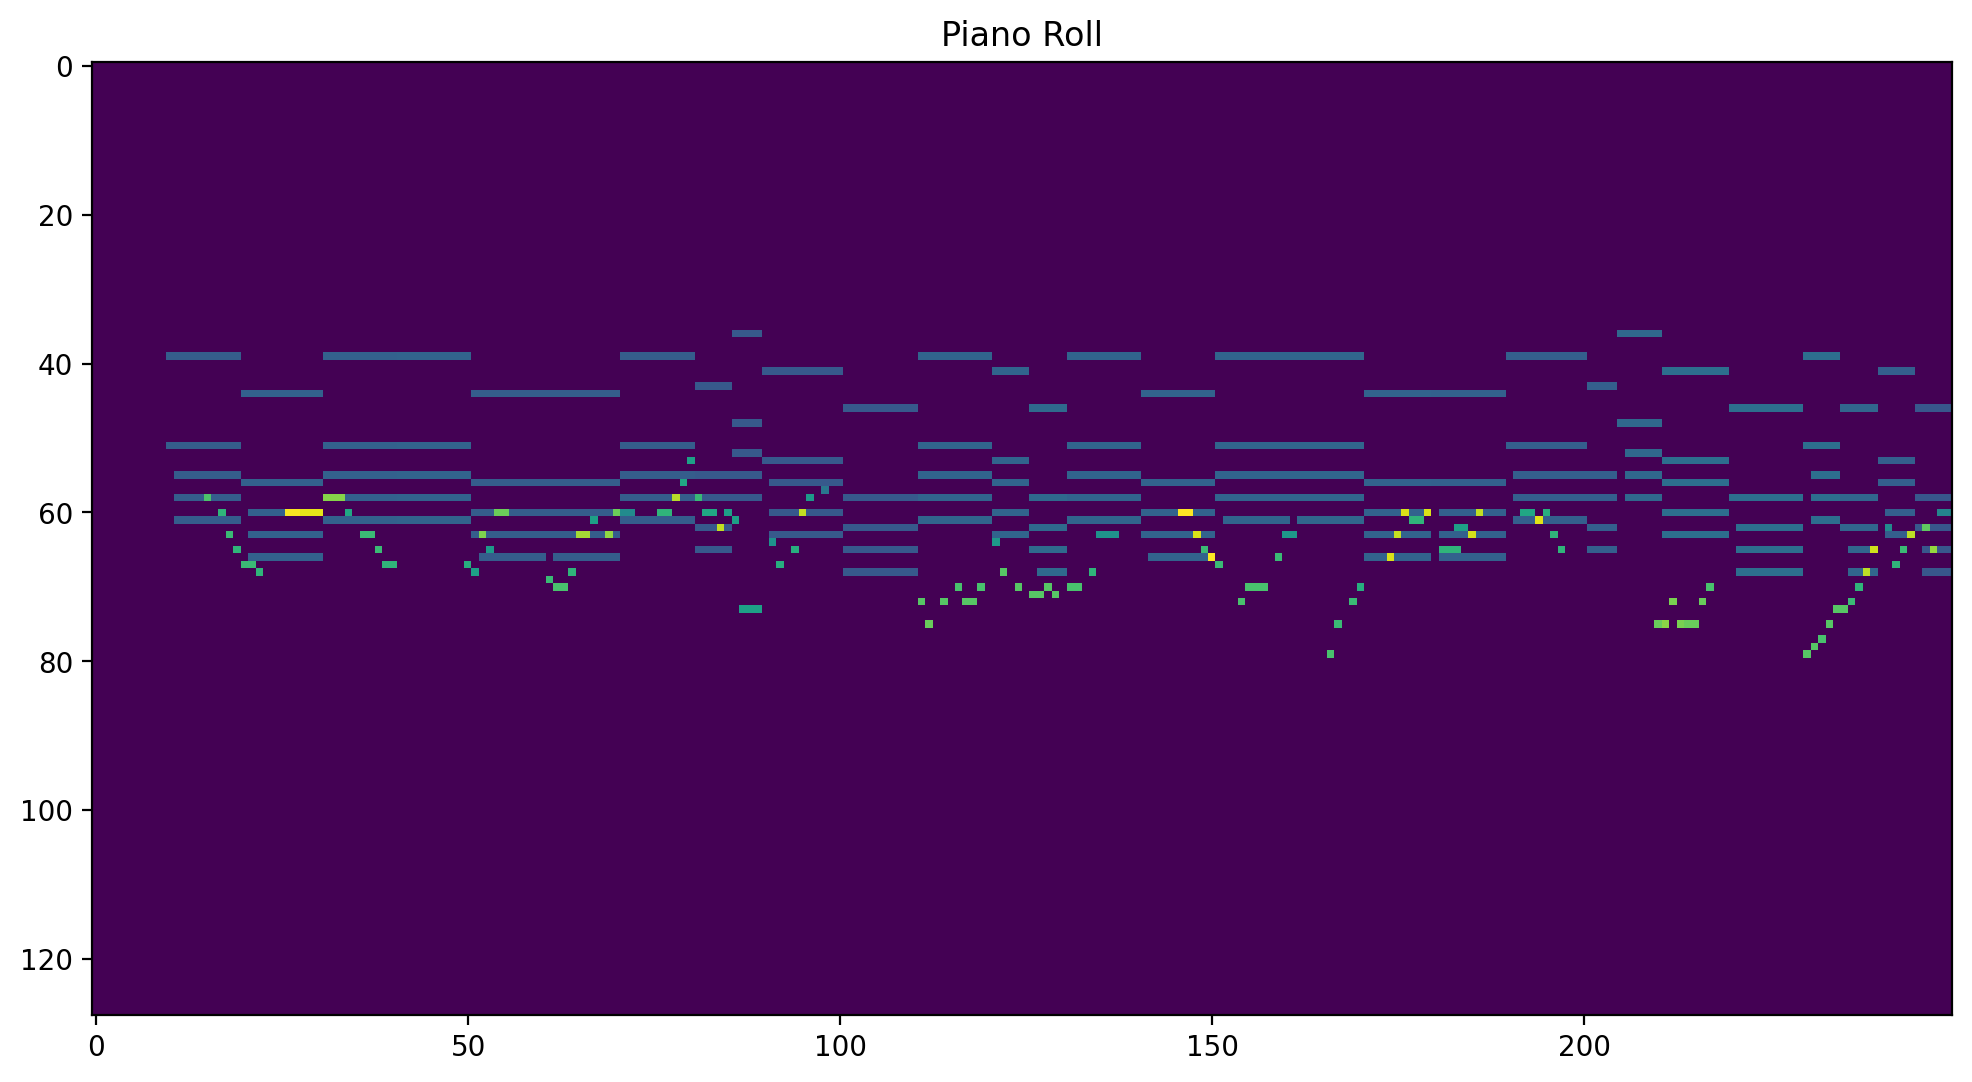

In [20]:
pr =piano_roll[:,:250]
plt.figure(figsize=(12,20),dpi = 200)
plt.imshow(pr)#,cmap = plt.cm.gray)
plt.title('Piano Roll')
plt.show()

In [166]:
S=np.zeros((Tx,Tx))
p('正在计算自相似矩阵...')
for i in range(Tx):
    S[i]=(np.sum(np.sqrt(np.square(x-x[i])),axis=1)) #欧氏距离

p(S)
# np.save('S of '+ file_name + '.npy',S)
# p('已储存相似度矩阵。')

正在计算自相似矩阵...
[[  0.   0.   0. ... 185. 185. 185.]
 [  0.   0.   0. ... 185. 185. 185.]
 [  0.   0.   0. ... 185. 185. 185.]
 ...
 [185. 185. 185. ...   0.   0.   0.]
 [185. 185. 185. ...   0.   0.   0.]
 [185. 185. 185. ...   0.   0.   0.]]


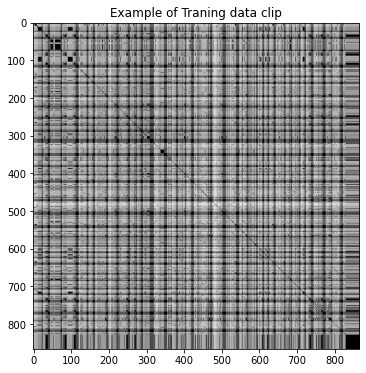

In [168]:
plt.figure(figsize=(6,6))
plt.imshow(S,cmap = plt.cm.gray)
plt.title('Example of Traning data clip')
plt.show()

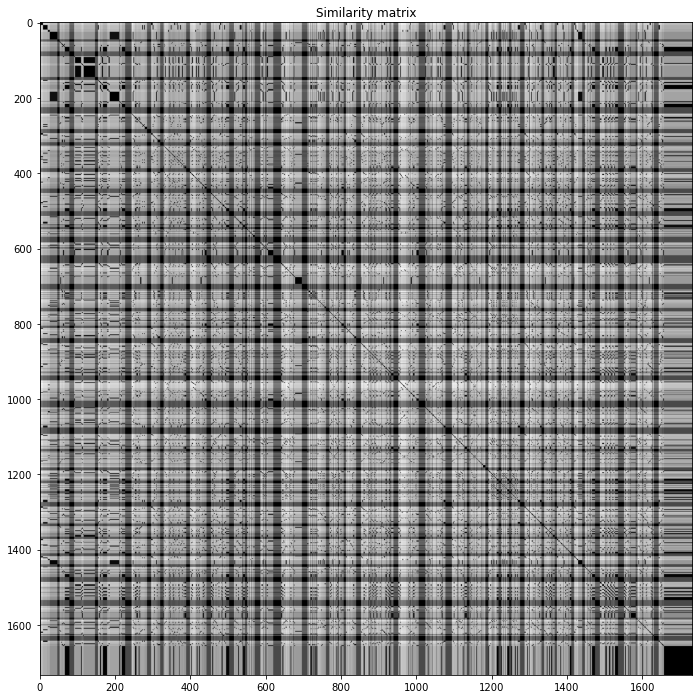

In [83]:
plt.figure(figsize=(12,12))
plt.imshow(S,cmap = plt.cm.gray)
plt.title('Similarity matrix')
plt.show()

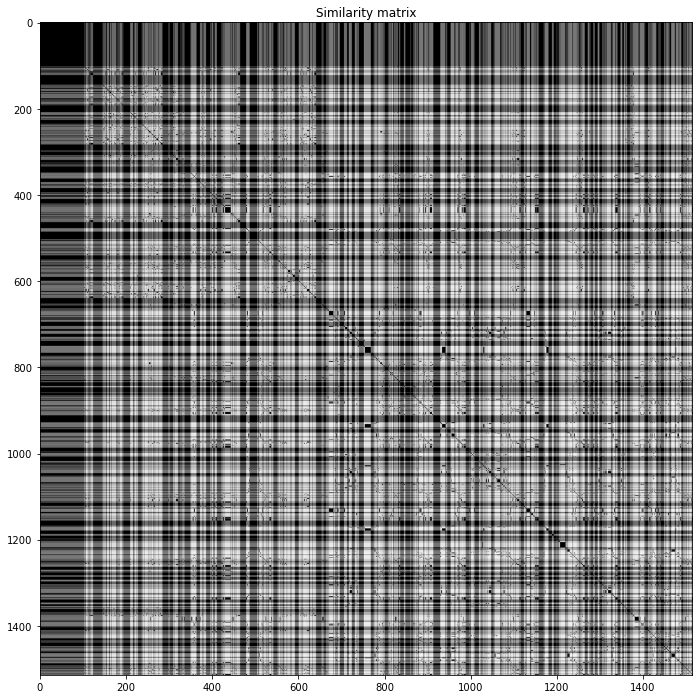

In [80]:
plt.figure(figsize=(12,12))
plt.imshow(S,cmap = plt.cm.gray)
plt.title('Similarity matrix')
plt.show()


In [111]:
y=np.array([1,2])
x=np.array([3,4])

In [122]:
KL =stats.entropy(x,y)

In [144]:
z = [1,2,3,4,5,6,7,8,9,7,5,6,4,2,4,5,6,1,8,9,4,5,6,8,4,2,6,4,8]

In [35]:
trans[0].pclass

array([0., 2., 2., 0., 0., 2., 2., 0., 7., 2., 0., 1.])

In [123]:
KL

0.019620080790526434

In [146]:
pd = stats.relfreq(z)

In [147]:
pd.frequency

array([0.06896552, 0.10344828, 0.03448276, 0.20689655, 0.        ,
       0.13793103, 0.17241379, 0.06896552, 0.13793103, 0.06896552])

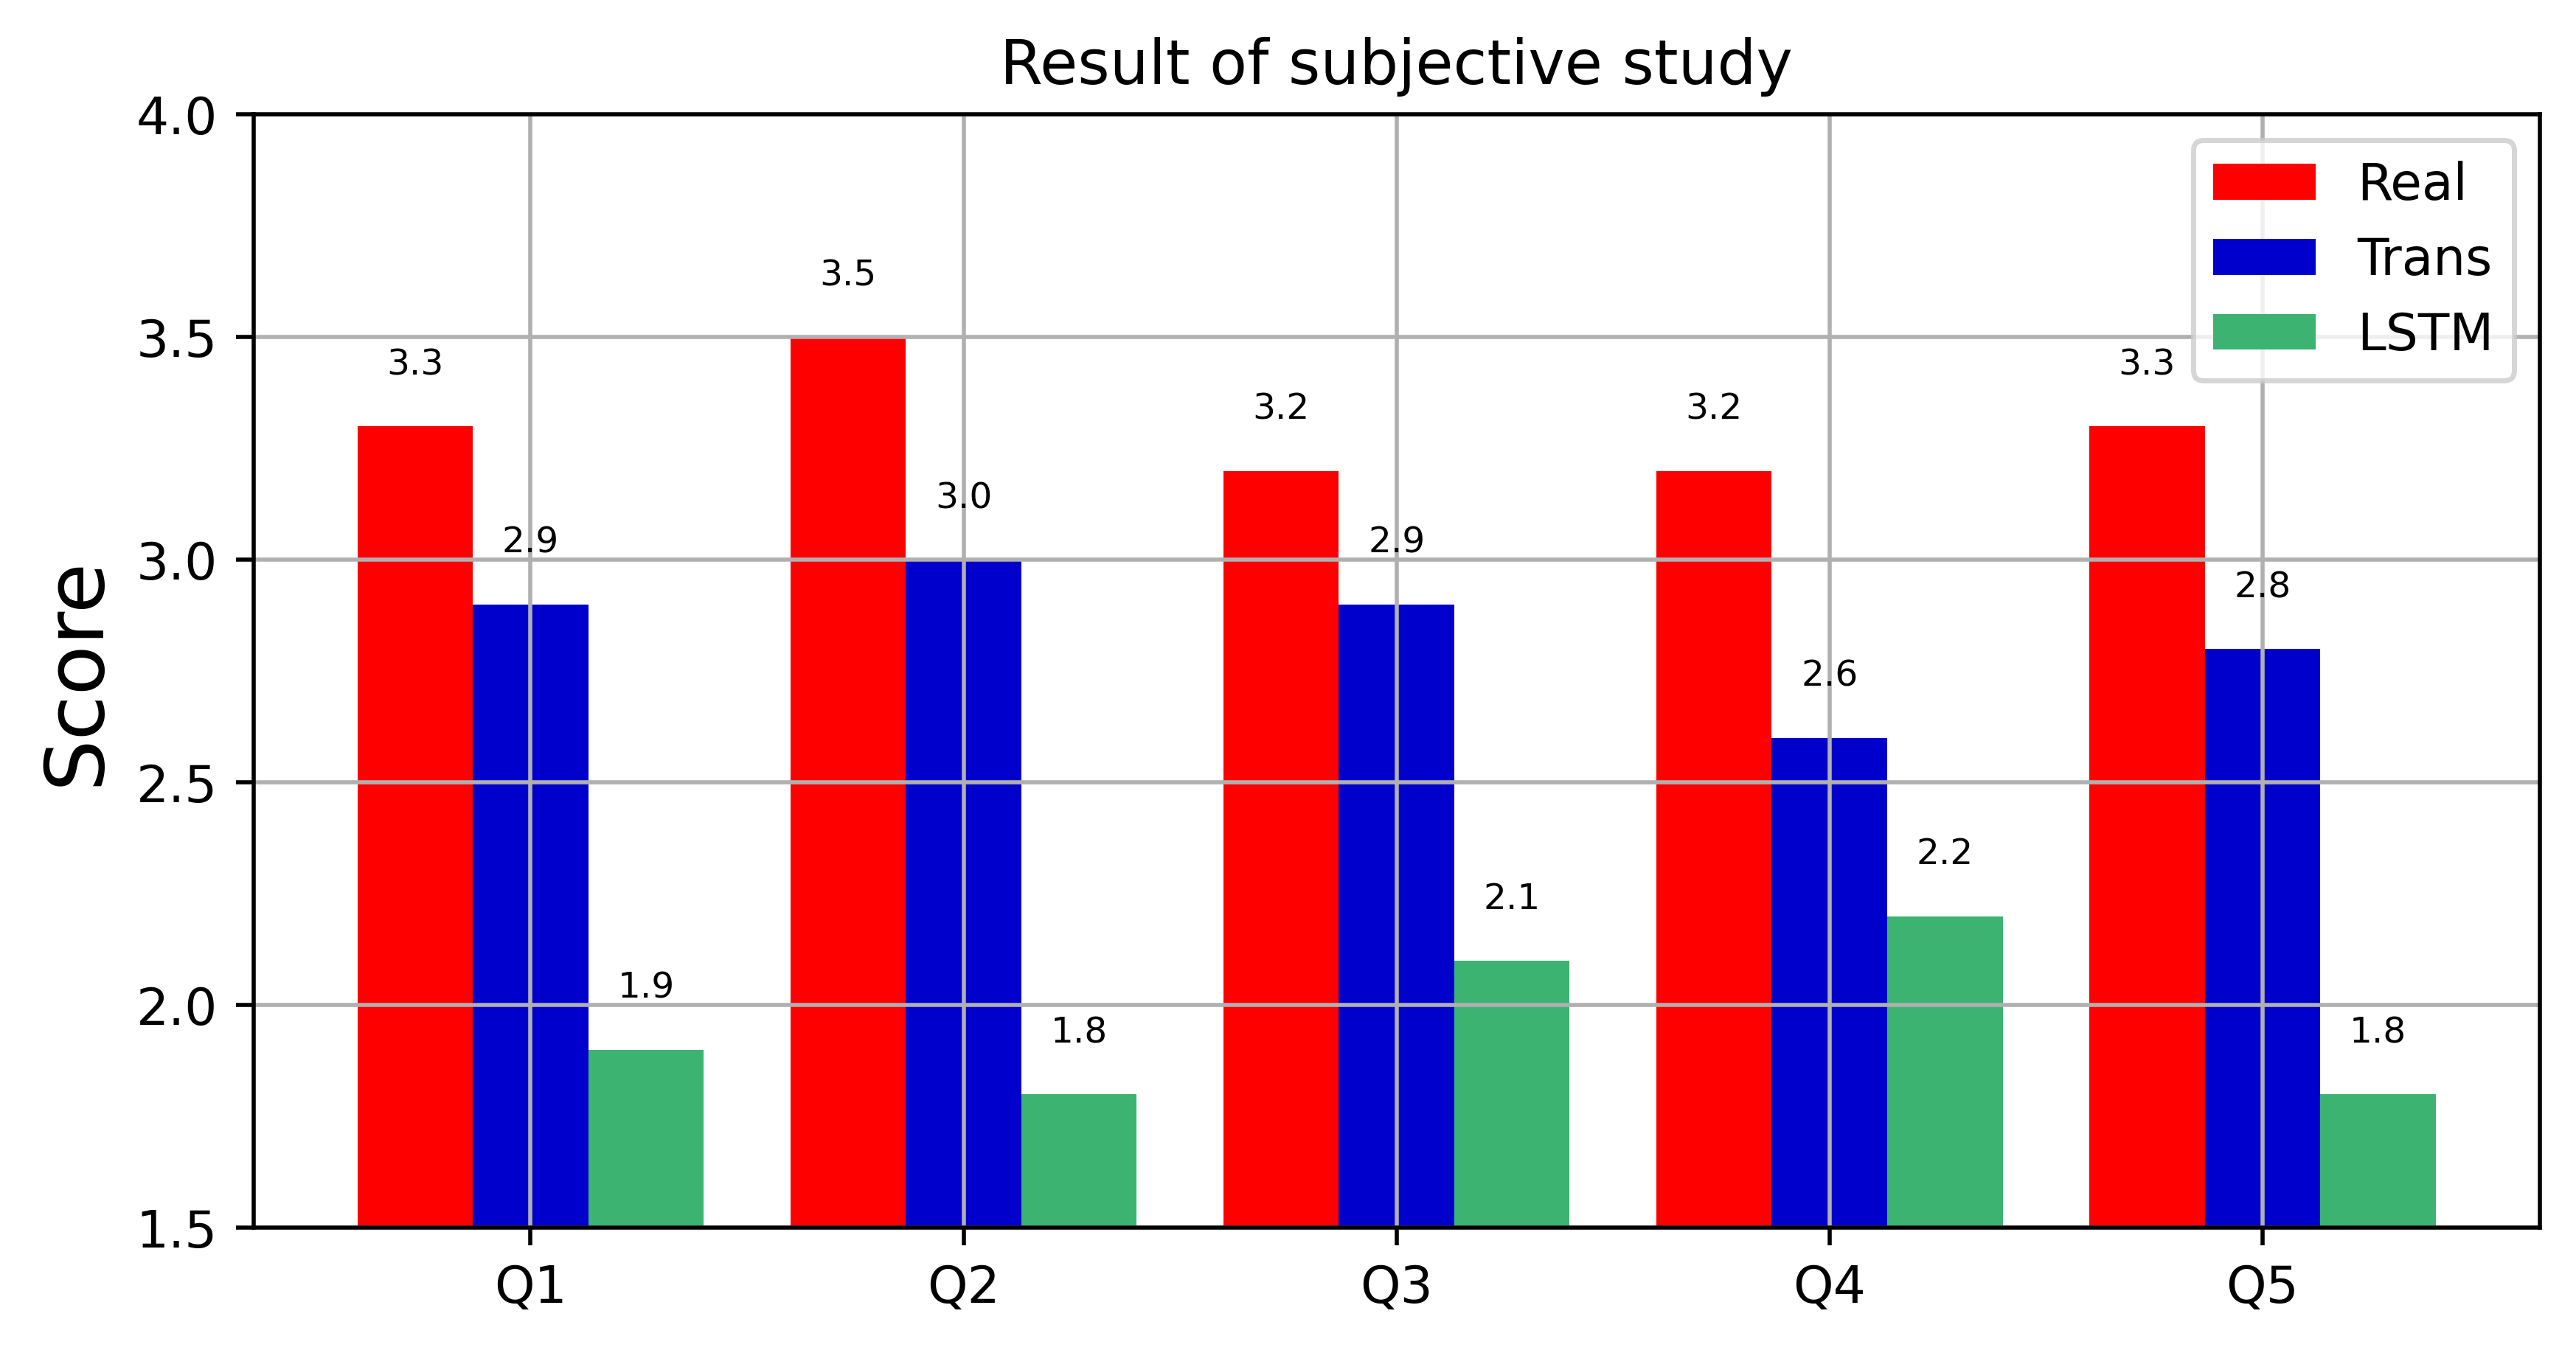

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
labels = ['Q1', 'Q2','Q3','Q4','Q5']
Real = [3.3,3.5,3.2,3.2,3.3]
Trans = [2.9,3.0,2.9,2.6,2.8]
LSTM = [1.9,1.8,2.1,2.2,1.8]  
plt.figure(dpi = 500,figsize=(8,4))
x = np.arange(len(labels))  # 标签位置
width = 0.1  # 柱状图的宽度，可以根据自己的需求和审美来改
total_width, n = 0.8, 3
width = total_width / n
x1 = x - width
x2 = x1+ width
x3 = x2 + width
plt.bar(x1,Real,width=width,label = 'Real',color = 'r')
plt.bar(x2,Trans,width=width,label = 'Trans',color = '#0000CD')
plt.bar(x3,LSTM,width=width,label = 'LSTM',color = '#3CB371')
# 为y轴、标题和x轴等添加一些文本。
plt.ylabel('Score', fontsize=16)
plt.title('Result of subjective study')
plt.xticks(x, labels)
for a, b in zip(x1, Real):
    plt.text(a, b + 0.1, '%.1f' % b, ha='center', va='bottom', fontsize=7)

for a, b in zip(x2, Trans):
    plt.text(a, b + 0.1, '%.1f' % b, ha='center', va='bottom', fontsize=7)
    
for a, b in zip(x3, LSTM):
    plt.text(a, b + 0.1, '%.1f' % b, ha='center', va='bottom', fontsize=7)
plt.ylim(ymin = 1.5,ymax =4)
plt.legend()
plt.grid()

plt.show()

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

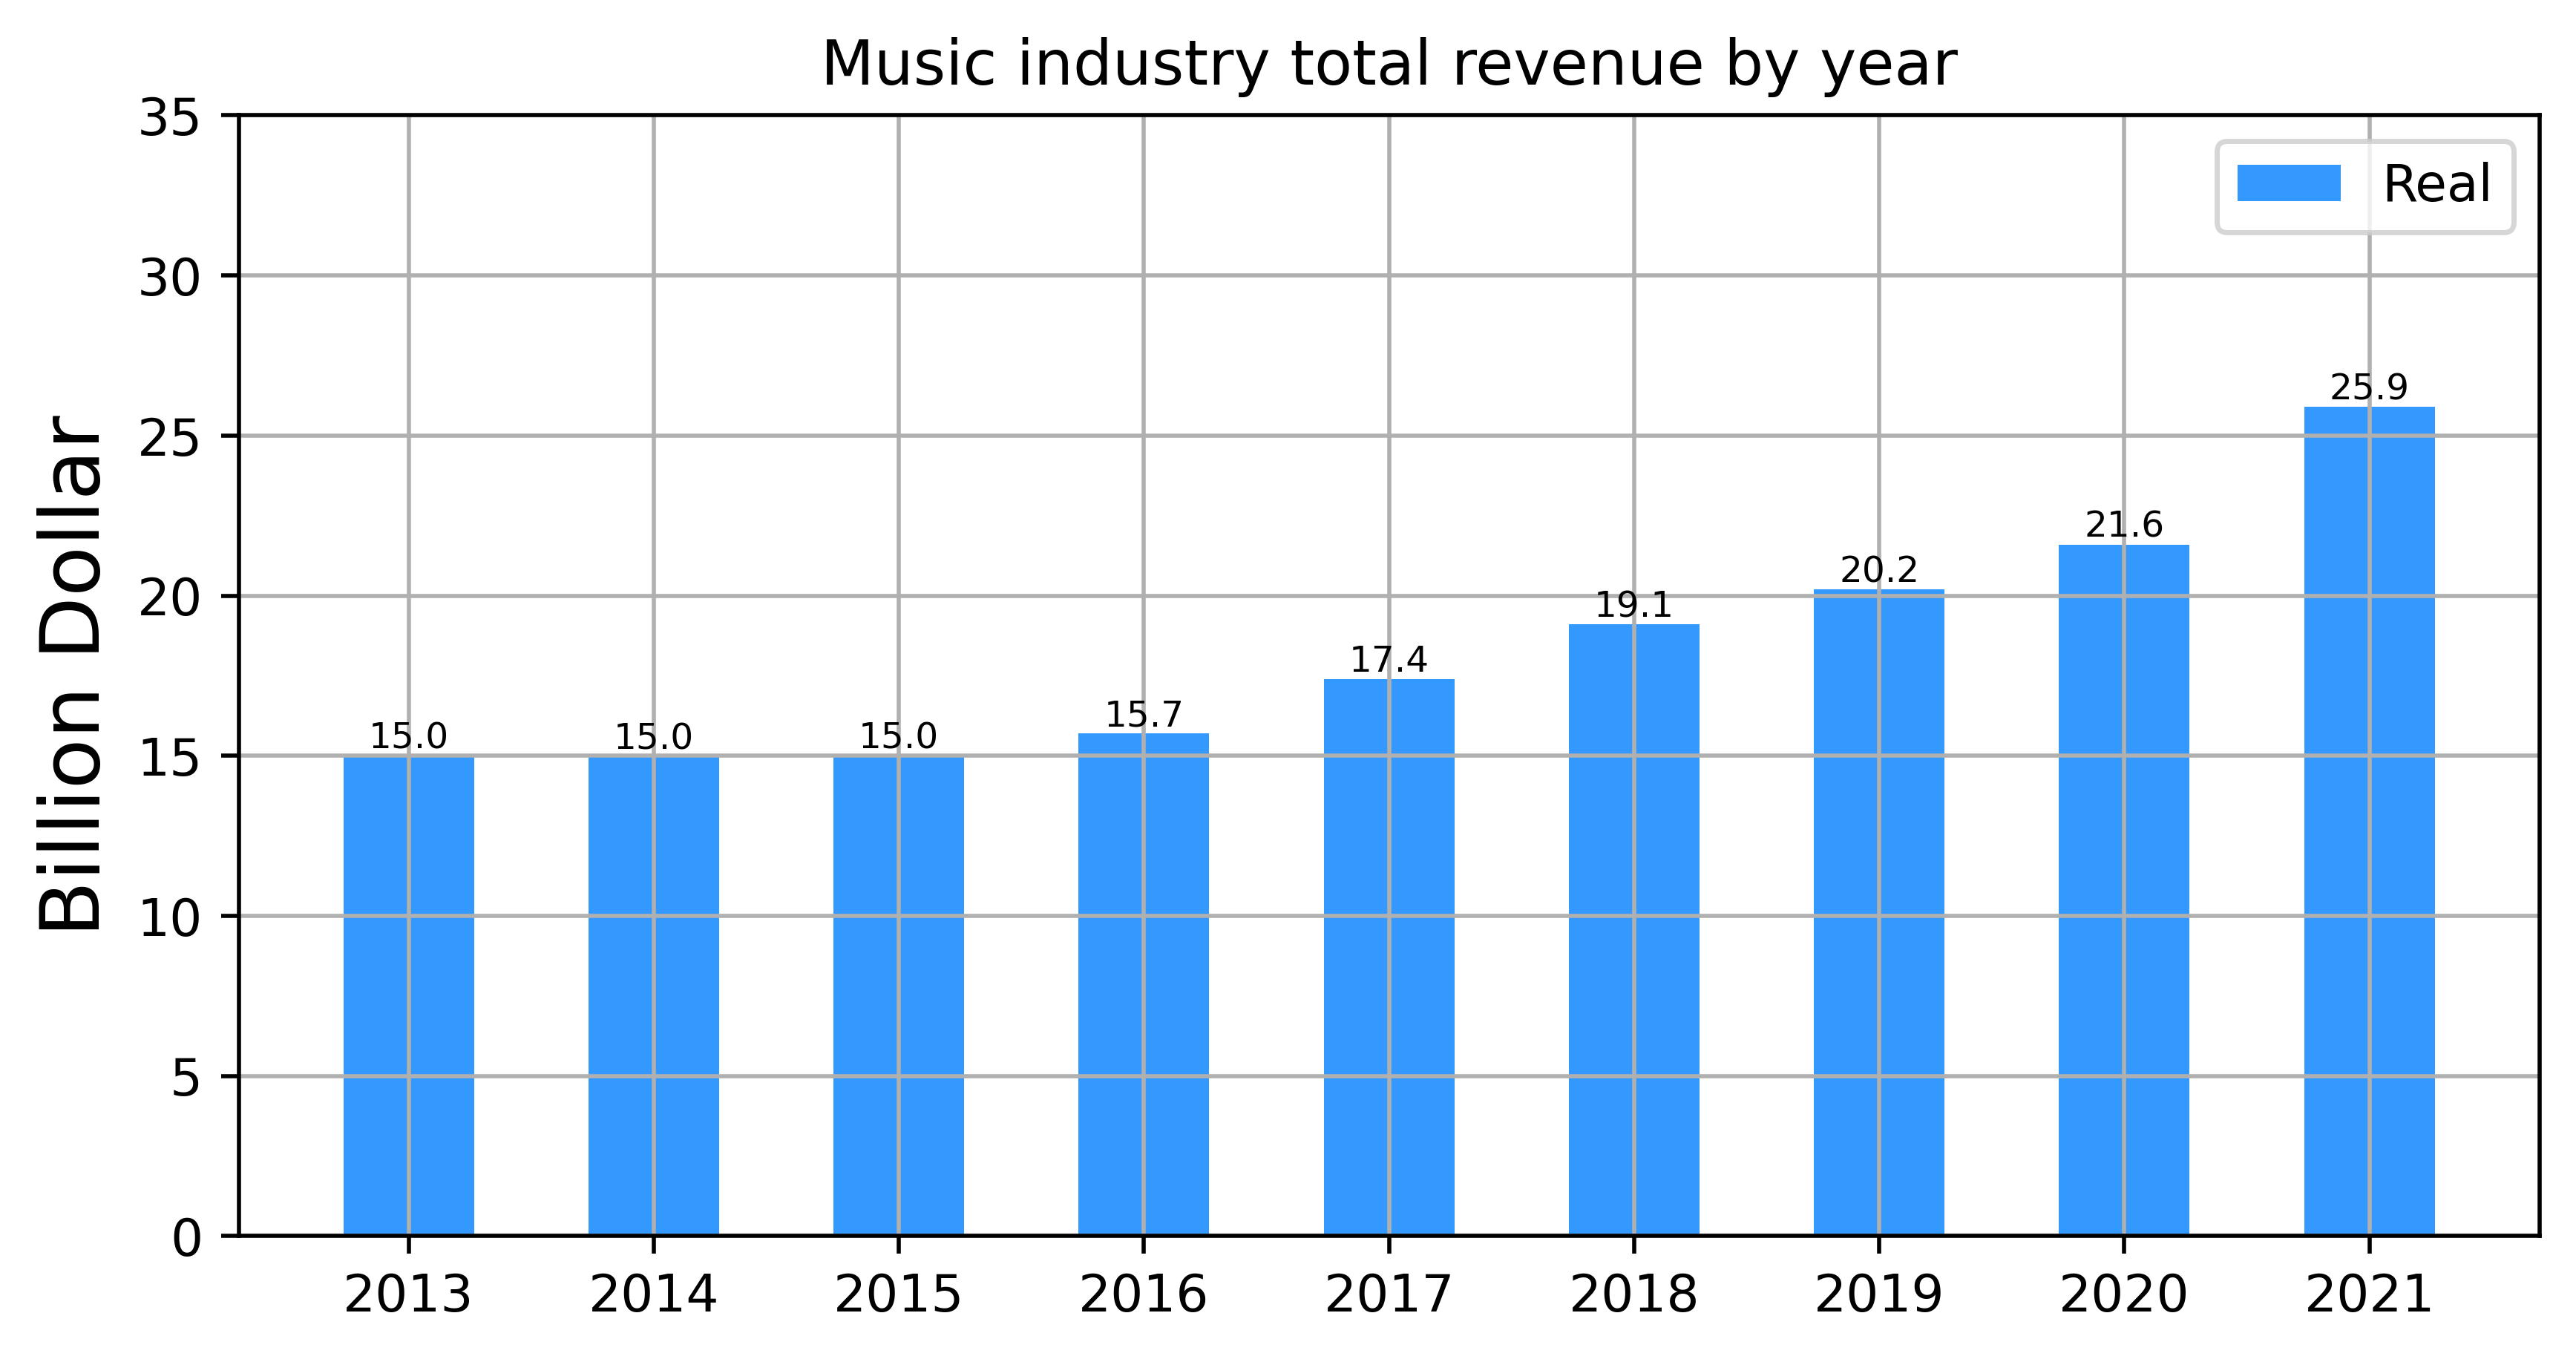

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
labels = ['2013', '2014','2015','2016','2017','2018','2019','2020','2021']
Real = [15,14.97,15,15.7,17.4,19.1,20.2,21.6,25.9]
plt.figure(dpi = 500,figsize=(8,4))
x = np.arange(len(labels))  # 标签位置
width = 0.5  # 柱状图的宽度，可以根据自己的需求和审美来改
total_width, n = 1.6, 3
width = total_width / n
plt.bar(x,Real,width=width,label = 'Real',color = '#3399FF')
# 为y轴、标题和x轴等添加一些文本。
plt.ylabel('Billion Dollar', fontsize=16)
plt.title('Music industry total revenue by year')
plt.xticks(x, labels)
for a, b in zip(x, Real):
    plt.text(a, b, '%.1f' % b, ha='center', va='bottom', fontsize=7)
plt.ylim(ymin = 0,ymax =35)
plt.legend()
plt.grid()

plt.show()